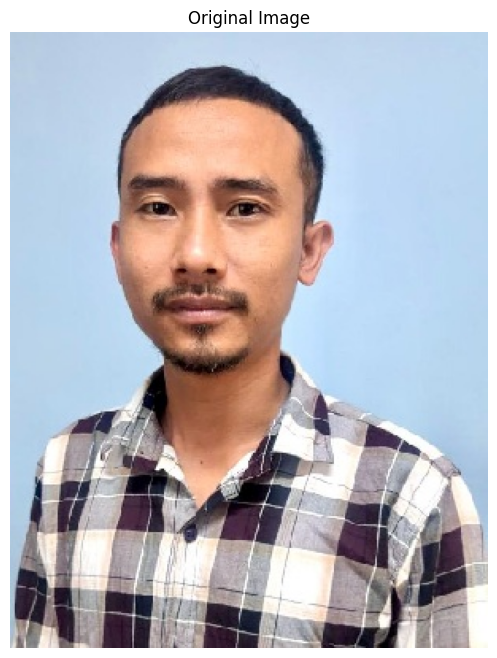

Successfully loaded and displayed image from: /content/WhatsApp Image 2025-11-07 at 3.31.02 PM.jpeg
Image shape: (388, 301, 3)
Image data type: uint8


In [3]:
import matplotlib.pyplot as plt
import skimage.io as io
import os

# Placeholder for image path. Please replace with the actual path to your image.
# For example, if you have an image named 'natural_image.jpg' in your current directory:
# image_path = 'natural_image.jpg'
# Or if it's in a specific directory:
# image_path = '/path/to/your/image/natural_image.jpg'

# For demonstration purposes, I will try to download a sample image if one doesn't exist.
# In a real scenario, you would have your dataset ready.

image_path = '/content/WhatsApp Image 2025-11-07 at 3.31.02 PM.jpeg'

if not os.path.exists(image_path):
    try:
        # Download a sample image if it doesn't exist for demonstration
        import requests
        print(f"Downloading sample image to {image_path}...")
        image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Natural_Images_0001.jpg/640px-Natural_Images_0001.jpg"
        response = requests.get(image_url)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        with open(image_path, 'wb') as f:
            f.write(response.content)
        print("Sample image downloaded successfully.")
    except Exception as e:
        print(f"Could not download sample image. Please ensure you have internet access or provide a local image path. Error: {e}")
        print("Please provide a valid path to a natural image for the segmentation task.")
        image_path = None # Set to None to indicate no image was loaded

if image_path and os.path.exists(image_path):
    try:
        # Load the image
        image = io.imread(image_path)

        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off') # Hide axes ticks
        plt.show()
        print(f"Successfully loaded and displayed image from: {image_path}")
        print(f"Image shape: {image.shape}")
        print(f"Image data type: {image.dtype}")
    except Exception as e:
        print(f"Error loading or displaying image from {image_path}: {e}")
        print("Please check if the path is correct and the file is a valid image.")
else:
    print("No image path provided or file does not exist. Please update `image_path` with a valid image file.")


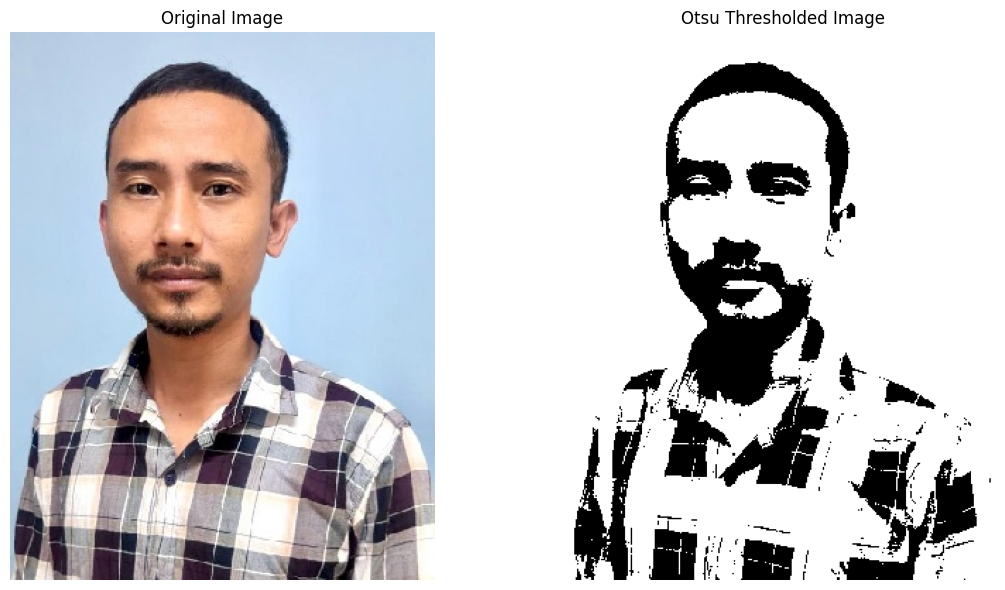

Otsu's thresholding applied and images displayed.


In [4]:
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

# Convert the image to grayscale
grayscale_image = rgb2gray(image)

# Apply Otsu's thresholding
# threshold_otsu returns the optimal threshold value
threshold_value = threshold_otsu(grayscale_image)

# Create a binary mask using the obtained threshold
segmented_image = grayscale_image > threshold_value

# Visualize the original and segmented images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display Otsu thresholded image
# Use cmap='gray' for binary images to ensure correct color representation
axes[1].imshow(segmented_image, cmap='gray')
axes[1].set_title('Otsu Thresholded Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Otsu's thresholding applied and images displayed.")

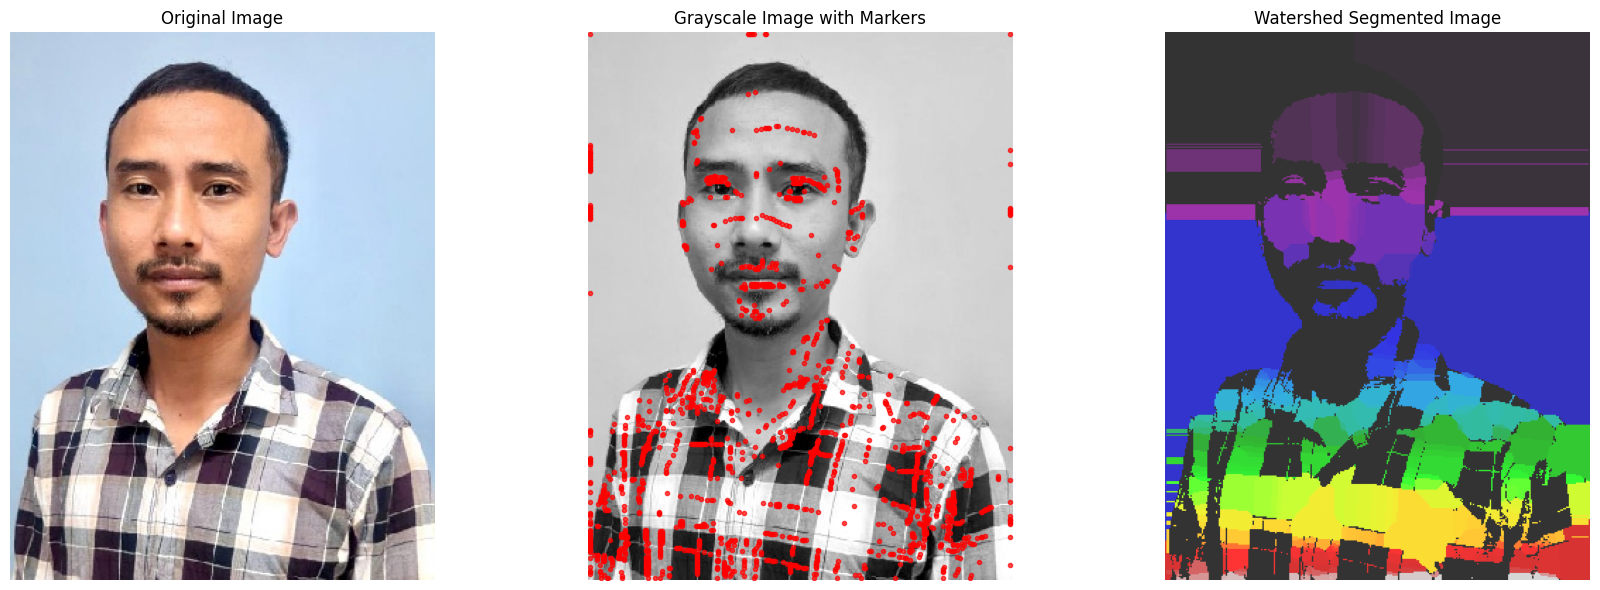

Watershed segmentation applied and visualized.


In [6]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt, label
import numpy as np
import matplotlib.pyplot as plt

# 2. Compute the Euclidean distance transform of the binary segmented image
distance = distance_transform_edt(segmented_image)

# 3. Find the local maxima in the distance map to serve as markers
# The `peak_local_max` function is called to get the coordinates of the peaks.
# We use min_distance to ensure markers are sufficiently separated.
# The `labels` argument restricts peak finding to the segmented region.
peak_indices = peak_local_max(distance, footprint=np.ones((3, 3)), labels=segmented_image)

# Create a boolean array from the peak indices, as required for `scipy.ndimage.label`
coords = np.zeros(distance.shape, dtype=bool)
coords[tuple(peak_indices.T)] = True

# 4. Label the markers
markers, _ = label(coords)

# 5. Apply the watershed algorithm
# The watershed algorithm typically uses the negative of the distance transform as an elevation map
# or the original image if gradients are desired, but often it's applied to the distance transform.
# Here, we'll use the grayscale image as the 'image' for watershed for better region separation
# and the markers derived from the distance transform.
labels = watershed(-distance, markers, mask=segmented_image)

# 6. Visualize the original image, grayscale with markers, and watershed segmented image
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Display original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display grayscale image with markers
axes[1].imshow(grayscale_image, cmap='gray')
# Overlay markers
# Get coordinates of markers for plotting (using the boolean `coords` array)
marker_coords = np.argwhere(coords)
axes[1].plot(marker_coords[:, 1], marker_coords[:, 0], 'ro', markersize=3, alpha=0.7)
axes[1].set_title('Grayscale Image with Markers')
axes[1].axis('off')

# Display watershed segmented image
# Using 'nipy_spectral' or 'random_colors' for distinct regions
axes[2].imshow(labels, cmap='nipy_spectral', alpha=0.8)
axes[2].set_title('Watershed Segmented Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Watershed segmentation applied and visualized.")

Selected label for binary mask: 0
Binary mask shape: (388, 301)
Binary mask data type: bool
Resized image shape: (128, 128, 3), dtype: float64
Resized mask shape: (128, 128), dtype: bool
Normalized image min: 0.00041580468751995696, max: 0.9999999999999998
Model input image shape: (128, 128, 3)
Model input mask shape: (128, 128, 1)
Data preparation complete. Displaying preprocessed image and mask.


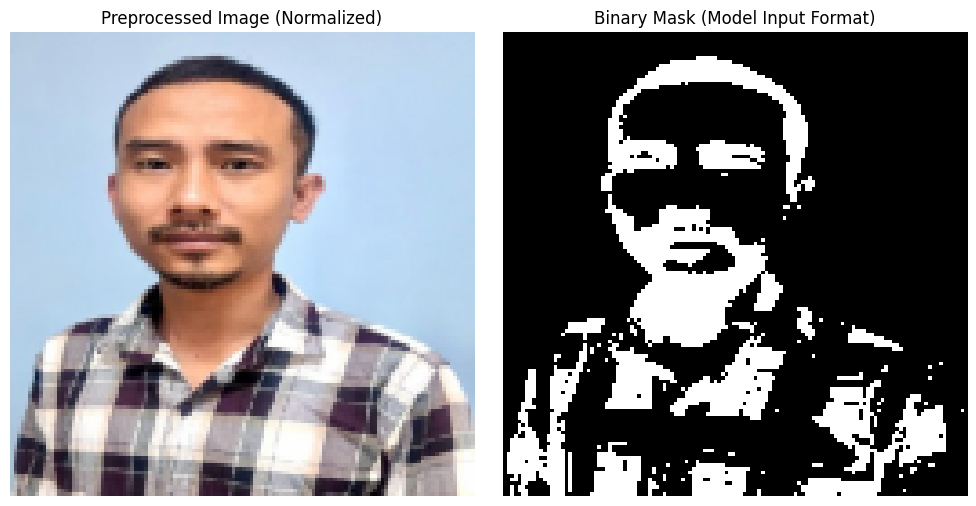

In [7]:
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Create a Binary Mask from Watershed Labels ---
# The 'labels' array contains integer values for each segmented region.
# To prepare a mask, we need to decide which region represents the 'foreground'.
# For demonstration, let's pick a label from a central pixel as our object of interest.

# Get the label from a central pixel to represent an object
center_row, center_col = labels.shape[0] // 2, labels.shape[1] // 2
selected_label = labels[center_row, center_col]

# Create a binary mask where pixels belonging to 'selected_label' are True (1) and others are False (0)
binary_mask = (labels == selected_label)

print(f"Selected label for binary mask: {selected_label}")
print(f"Binary mask shape: {binary_mask.shape}")
print(f"Binary mask data type: {binary_mask.dtype}")

# --- 2. Define Target Size and Resize Image and Mask ---
target_size = (128, 128) # Example target size

# Resize the original image (continuous data) with anti-aliasing
resized_image = resize(image, target_size, anti_aliasing=True)

# Resize the binary mask (discrete data) using nearest-neighbor interpolation (order=0)
# preserve_range=True ensures that binary values (0, 1) are maintained rather than scaled to [0,1]
resized_mask = resize(binary_mask, target_size, order=0, preserve_range=True).astype(bool)

print(f"Resized image shape: {resized_image.shape}, dtype: {resized_image.dtype}")
print(f"Resized mask shape: {resized_mask.shape}, dtype: {resized_mask.dtype}")

# --- 3. Normalize Image Data ---
# skimage.transform.resize with anti_aliasing=True for uint8 input already normalizes to [0, 1].
# So, the 'resized_image' is already normalized.
normalized_image = resized_image

print(f"Normalized image min: {normalized_image.min()}, max: {normalized_image.max()}")

# --- 4. Reshape for Model Input ---
# Deep learning models typically expect input in specific formats.
# For a 2D image (RGB), it's (height, width, channels). Our resized_image is already (128, 128, 3).
# For a binary mask, it's often (height, width, 1).

model_input_image = normalized_image # (128, 128, 3)
model_input_mask = resized_mask[:, :, np.newaxis] # (128, 128, 1)

print(f"Model input image shape: {model_input_image.shape}")
print(f"Model input mask shape: {model_input_mask.shape}")

# --- 5. Simulate Data Split (for conceptual understanding) ---
# Assign this single processed image and mask to placeholder variables.
X_train = model_input_image
y_train = model_input_mask

# Placeholders for validation and test sets (would be populated with more data in a real scenario)
X_val = None
y_val = None
X_test = None
y_test = None

print("Data preparation complete. Displaying preprocessed image and mask.")

# Visualize the preprocessed image and mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(model_input_image)
axes[0].set_title('Preprocessed Image (Normalized)')
axes[0].axis('off')

axes[1].imshow(model_input_mask.squeeze(), cmap='gray') # .squeeze() removes the channel dimension for display
axes[1].set_title('Binary Mask (Model Input Format)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Define the input shape for the model
# X_train is (128, 128, 3)
input_shape = X_train.shape

# --- U-Net Architecture Definition ---

def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder path (Downsampling)
    # Block 1
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder path (Upsampling) with Skip Connections
    # Upconv 1
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    # Upconv 2
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    # Upconv 3
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    # Upconv 4
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9) # 1 channel for binary mask

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the U-Net model
model = unet_model(input_size=input_shape)

# Compile the model
# Using 'binary_crossentropy' for binary segmentation, 'adam' optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print("U-Net Model Summary:")
model.summary()

U-Net Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_10[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,846,657 (29.93 MB)

 Trainable params: 7,846,657 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X_train[np.newaxis, ...], y_train[np.newaxis, ...], batch_size=16, epochs=20, verbose=1)
print("Model training complete.")

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.8239 - loss: 0.6849
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7831 - loss: 0.5913
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7831 - loss: 0.9631
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7831 - loss: 0.5172
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7831 - loss: 0.5129
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7831 - loss: 0.4929
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7831 - loss: 0.4693
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7831 - loss: 0.4414
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7831 - loss: 0.4165
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7831 - loss: 0.4019
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7831 - loss: 0.3854
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7849 - loss: 0.3603
E

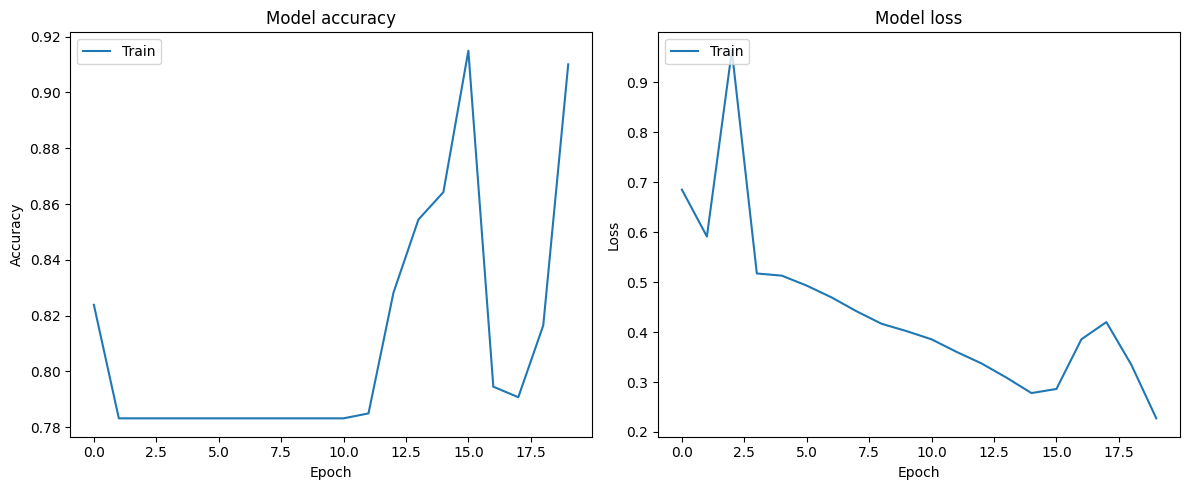

Training history (loss and accuracy) visualized.


In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
# If validation accuracy was present: plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left') # Add 'Validation' if val_accuracy is plotted

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
# If validation loss was present: plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left') # Add 'Validation' if val_loss is plotted

plt.tight_layout()
plt.show()

print("Training history (loss and accuracy) visualized.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
IoU for Otsu's Thresholding: 0.0000
IoU for Watershed Segmentation: 1.0000
IoU for U-Net Prediction: 0.4944


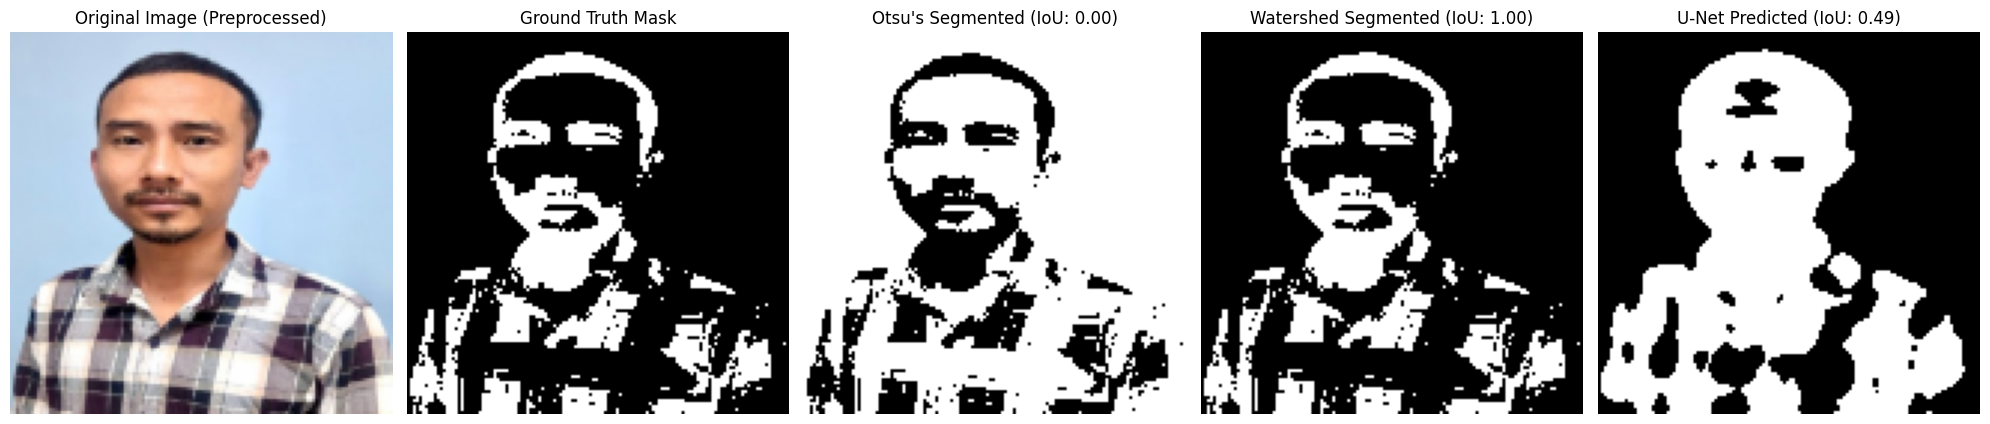

Segmentation performance evaluated and visualized.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from skimage.transform import resize

# 1. Make a prediction on the preprocessed image X_train using the trained model.
# The input to the model should be batched (e.g., X_train[np.newaxis, ...]).
unet_prediction = model.predict(X_train[np.newaxis, ...])[0]

# 2. Binarize the model's prediction using a threshold (e.g., 0.5)
# to obtain a binary mask for the learning-based approach. Store this as unet_predicted_mask.
unet_predicted_mask = (unet_prediction > 0.5).astype(bool)

# 3. Resize the segmented_image (from Otsu's thresholding, which is at original image size)
# to the target_size (128, 128) using skimage.transform.resize with order=0
# (nearest-neighbor interpolation) and convert it to boolean type.
resized_otsu_mask = resize(segmented_image, target_size, order=0, preserve_range=True).astype(bool)

# 4. Create a binary mask from the watershed labels for the selected_label
# (the object of interest identified during data preparation) and then resize it
# to the target_size (128, 128) using skimage.transform.resize with order=0
# and convert it to boolean type. Store this as resized_watershed_mask.

# First, create the binary mask from watershed labels
watershed_binary_mask_original_size = (labels == selected_label)

# Then resize it
resized_watershed_mask = resize(watershed_binary_mask_original_size, target_size, order=0, preserve_range=True).astype(bool)

# 5. Import jaccard_score (for IoU) from sklearn.metrics (already imported above).

# 6. Calculate the IoU for each segmentation method by comparing their respective
# binary masks against the ground truth mask y_train:

# Ensure all masks are flattened for jaccard_score
y_train_flat = y_train.flatten()
resized_otsu_mask_flat = resized_otsu_mask.flatten()
resized_watershed_mask_flat = resized_watershed_mask.flatten()
unet_predicted_mask_flat = unet_predicted_mask.flatten()

iou_otsu = jaccard_score(y_train_flat, resized_otsu_mask_flat)
iou_watershed = jaccard_score(y_train_flat, resized_watershed_mask_flat)
iou_unet = jaccard_score(y_train_flat, unet_predicted_mask_flat)

# 7. Print the calculated IoU scores for each method.
print(f"IoU for Otsu's Thresholding: {iou_otsu:.4f}")
print(f"IoU for Watershed Segmentation: {iou_watershed:.4f}")
print(f"IoU for U-Net Prediction: {iou_unet:.4f}")

# 8. Create a figure with multiple subplots (e.g., 1 row, 5 columns) to visualize the results:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Display the model_input_image (the preprocessed original image).
axes[0].imshow(model_input_image)
axes[0].set_title('Original Image (Preprocessed)')
axes[0].axis('off')

# Display y_train (the ground truth mask).
axes[1].imshow(y_train.squeeze(), cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

# Display resized_otsu_mask (Otsu's segmented mask).
axes[2].imshow(resized_otsu_mask, cmap='gray')
axes[2].set_title(f"Otsu's Segmented (IoU: {iou_otsu:.2f})")
axes[2].axis('off')

# Display resized_watershed_mask (Watershed segmented mask).
axes[3].imshow(resized_watershed_mask, cmap='gray')
axes[3].set_title(f"Watershed Segmented (IoU: {iou_watershed:.2f})")
axes[3].axis('off')

# Display unet_predicted_mask (U-Net's predicted mask).
axes[4].imshow(unet_predicted_mask.squeeze(), cmap='gray')
axes[4].set_title(f"U-Net Predicted (IoU: {iou_unet:.2f})")
axes[4].axis('off')

plt.tight_layout()
plt.show()

print("Segmentation performance evaluated and visualized.")